# Spectrum Quality Prediction

In this vignette, we will use Depthcharge to predict the "quality" of a tandem mass spectrum; that is, the likelihood that a each tandem mass spectrum will be identified during a database search.
To do so, we will download a subset of files that were used to construct MassIVE-KB using PPX and perform a database search against the human proteome with Sage. 
Spectra that are matched to a peptide below 1% FDR will be labeled as high-quality, wereas spectra that failed to be matched will be annotated as low-quality for the purposes of our classifier.

This vignette is intended to run on Google Colab using a GPU instance.

## Install Dependencies

First we install PPX, Depthcharge and Polars, which we'll use in these analyses:

In [57]:
%%bash
pip install polars lightning seaborn torchmetrics ppx xgboost scikit-learn
pip install -e "../../../../src/depthcharge/"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 6.9 MB/s eta 0:00:00m eta 0:00:010:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 7.2 MB/s eta 0:00:000:00:01
Obtaining file:///Users/wfondrie/src/depthcharge
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for depthcharge-ms (pyproject.toml): started
  Building editable for depthcharge-ms (pyproject.toml): finished with status 'done'
  Created wheel for depthcharge-ms: filename=depthcharge_ms-0.4.3.dev3+g9abe83b-0.editable-py3-none-any.whl size=7585 sha

Then we download Sage for our database search:

In [2]:
%%bash
#curl -sL https://github.com/lazear/sage/releases/download/v0.14.7/sage-v0.14.7-x86_64-unknown-linux-gnu.tar.gz \
curl -sL https://github.com/lazear/sage/releases/download/v0.14.7/sage-v0.14.7-aarch64-apple-darwin.tar.gz \
    | tar xz \
    && mv */sage ./sage

./sage --help

Usage: sage [OPTIONS] <parameters> [mzml_paths]...

🔮 Sage 🧙 - Proteomics searching so fast it feels like magic!

Written by Michael Lazear <michaellazear92@gmail.com>
Version 0.14.6

Arguments:
  <parameters>     Path to configuration parameters (JSON file)
  [mzml_paths]...  Paths to mzML files to process. Overrides mzML files listed in the configuration file.

Options:
  -f, --fasta <fasta>
          Path to FASTA database. Overrides the FASTA file specified in the configuration file.
  -o, --output_directory <output_directory>
          Path where search and quant results will be written. Overrides the directory specified in the configuration file.
      --batch-size <batch-size>
          Number of files to load and search in parallel (default = # of CPUs/2)
      --parquet
          Write search output in parquet format instead of tsv
      --annotate-matches
          Write matched fragments output file.
      --write-pin
          Write percolator-compatible `.pin` output files

Finally, we download the UniProt canonical human proteome FASTA for our database search:

In [3]:
%%bash
curl -sL "https://rest.uniprot.org/uniprotkb/stream?compressed=true&format=fasta&query=%28%28proteome%3AUP000005640%29+AND+reviewed%3Dtrue%29" \
    | gunzip -c > human.fasta

head human.fasta

>sp|A0A087X1C5|CP2D7_HUMAN Putative cytochrome P450 2D7 OS=Homo sapiens OX=9606 GN=CYP2D7 PE=5 SV=1
MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNLLHVDFQNTPYCFDQ
LRRRFGDVFSLQLAWTPVVVLNGLAAVREAMVTRGEDTADRPPAPIYQVLGFGPRSQGVI
LSRYGPAWREQRRFSVSTLRNLGLGKKSLEQWVTEEAACLCAAFADQAGRPFRPNGLLDK
AVSNVIASLTCGRRFEYDDPRFLRLLDLAQEGLKEESGFLREVLNAVPVLPHIPALAGKV
LRFQKAFLTQLDELLTEHRMTWDPAQPPRDLTEAFLAKKEKAKGSPESSFNDENLRIVVG
NLFLAGMVTTSTTLAWGLLLMILHLDVQRGRRVSPGCPIVGTHVCPVRVQQEIDDVIGQV
RRPEMGDQAHMPCTTAVIHEVQHFGDIVPLGVTHMTSRDIEVQGFRIPKGTTLITNLSSV
LKDEAVWKKPFRFHPEHFLDAQGHFVKPEAFLPFSAGRRACLGEPLARMELFLFFTSLLQ
HFSFSVAAGQPRPSHSRVVSFLVTPSPYELCAVPR


## Load Libraries

Now we load all of the libraries we'll need to generate our datasets, train a model, and plot our results.

In [21]:
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import polars as pl
import ppx
import depthcharge as dc
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import lightning as L

from depthcharge.data import SpectrumDataset
from depthcharge.transformers import SpectrumTransformerEncoder
from depthcharge.feedforward import FeedForward
from ppx import MassiveProject
from torch.utils.data import DataLoader
from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from torchmetrics.classification import BinaryAUROC
from lance.sampler import ShardedBatchSampler
from xgboost import XGBClassifier

Path("logs").mkdir(exist_ok=True)
Path("data").mkdir(exist_ok=True)
ppx.set_data_dir("data")

L.pytorch.utilities.disable_possible_user_warnings()

## Create Our Datasets

We'll now download a random subset of mzML files used to create MassIVE-KB, and search them using Sage. 
The spectra identified by Sage at 1% FDR will be our positive examples, whereas the rest will be our negative examples.

First we select random files for our train, test, and validation splits from the subset of MassIVE-KB from high-resolution instruments with HCD fragmentation: 

In [2]:
n_train = 1
n_valid = 1
n_test = 1

mskb_files = (
    pl.read_csv(
        "https://raw.githubusercontent.com/wfondrie/2024_depthcharge-demos/"
        "main/data/massivekb_v2.0.15-hcd-files.tsv",
        separator="\t",
    )
    .select(
        pl.col("spectrum_filename").
        str.splitn("/", 2)
        .struct.rename_fields(["acc", "file"])
    )
    .unnest("spectrum_filename")
    .sample(fraction=1, seed=1)
    .group_by("acc", maintain_order=True)
    .head(1)
    .sample(fraction=1, seed=1)
    .rows()
)

train_remote_files = mskb_files[:n_train]
valid_remote_files = mskb_files[n_train:(n_train + n_valid)]
test_remote_files = mskb_files[(n_train + n_valid):(n_train + n_valid + n_test)]

Now we need to download all of the files:

In [3]:
mzml_files = []
for split in (train_remote_files, valid_remote_files, test_remote_files):
    split_files = []
    for acc, fname in split:
        proj = MassiveProject(acc)
        loc = proj.local_files(fname)[0]
        if not loc:
            loc = proj.download(fname)
            
        split_files.append(str(loc))

    mzml_files.append(split_files)

mzml_files = {k: f for k, f in zip(["train", "valid", "test"], mzml_files)}

Now we perform a database search with Sage using generic high-resolution parameters:

In [4]:
sage_config = {
    "database": {"bucket_size": 8192, "fasta": "human.fasta"},
    "precursor_tol": {"da": [-500, 500]},
    "fragment_tol": {"ppm": [-10, 10]},
    "static_mods": {"C": 57.0215},
    "variable_mods": {"M": [15.9949]},
}

with Path("sage.json").open("w+") as cfg:
    json.dump(sage_config, cfg)

search_results = {}
for split, split_files in mzml_files.items():
    search_results[split] = Path(f"{split}/results.sage.parquet")
    if not search_results[split].exists():
        print(f"Searching {split} (this may take a few minutes...")
        !./sage --parquet --output_directory {split} sage.json {" ".join(split_files)} 2> logs/{split}.log 1> /dev/null

Finally, we can assemble our Depthcharge datasets for training and validation. However, we'll wait to assemble our test set until the very end, after all model training has been performed.

In [6]:
datasets = {}
for split, batch_size in [("train", 128), ("valid", 1024)]:
    print(f"Creating the {split} dataset...")
    label_df = (
        pl.scan_parquet(search_results[split])
        .filter(pl.col("spectrum_q") <= 0.01)
        .select(
            "filename",
            pl.col("scannr").str.extract("scan=(.*)").cast(pl.Int64)
        )
        .rename({"filename": "peak_file", "scannr": "scan_id"})
        .with_columns(pl.lit(True).alias("label"))
        .collect()
    )

    datasets[split] = SpectrumDataset(
        mzml_files[split],
        batch_size=batch_size,
        path=f"{split}.lance", 
        parse_kwargs={"metadata_df": label_df},
        with_row_id=False,
        samples=100000 if split == "train" else 0, # 100K random batches / epoch.
    )

Creating the train dataset...


3B10-1.mzML:   0%|          | 0/26981 [00:00<?, ? spectra/s]

Creating the valid dataset...


CHPP_97H_RP10_1.mzML:   0%|          | 0/21803 [00:00<?, ? spectra/s]

## Create a Transformer Model

We will train a Transformer encoder model to predict the "quality" of each mass spectrum. 
Here, we create a PyTorch Lightning module using modules from Depthcharge to build our complete model.
For the loss function, we will use binary cross-entropy loss and we'll use Adam as our optimizer.

In [39]:
class SpectrumClassifier(L.LightningModule):
    """A model for clssifying mass spectra by quality."""
    def __init__(self):
        """Initialize the model."""
        super().__init__()
        self.encoder = SpectrumTransformerEncoder(n_layers=1)
        self.head = FeedForward(128, 1, layers=3, append=nn.Sigmoid())
        self.auroc = BinaryAUROC()
    
    def forward(self, X):
        """The forward pass."""
        return self.head(self.encoder(**X)[0].sum(1))

    def step(self, batch, step_type):
        """A single step"""
        Y = batch["label"].type_as(batch["mz_array"])
        Y_hat = self(batch).flatten()
        loss = F.binary_cross_entropy(Y_hat, Y)
        self.log(f"{step_type}_loss", loss.item(), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        if step_type == "valid":
            self.auroc(Y_hat, Y)
            self.log(f"{step_type}_auroc", self.auroc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        """The training step."""
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        """The validation step."""
        return self.step(batch, "valid")

    def predict_step(self, batch, batch_idx):
        """The predict step."""
        return self(batch)

    def configure_optimizers(self):
        """Configure optimizers for training."""
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## Fit Our Model

In [40]:
train_loader = DataLoader(datasets["train"], batch_size=None, num_workers=1, persistent_workers=True)
valid_loader = DataLoader(datasets["valid"], batch_size=None, num_workers=1, persistent_workers=True)
logger = CSVLogger("logs", "model", version=0)
trainer = L.Trainer(max_epochs=10, accelerator="cpu", logger=logger)

model = SpectrumClassifier()
trainer.fit(model, train_loader, valid_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/wfondrie/proj/2024_depthcharge-demos/notebooks/spectrum-quality/env/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory logs/model/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/wfondrie/proj/2024_depthcharge-demos/notebooks/spectrum-quality/env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory logs/model/version_0/checkpoints exists and is not empty.

  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | SpectrumTransformerEncoder | 362 K 
1 | head    | FeedForward                | 15.0 K
2 | auroc   | BinaryAUROC                | 0     
-------------------------------------------------------

Sanity Checking: |                                                                                            …

/Users/wfondrie/proj/2024_depthcharge-demos/notebooks/spectrum-quality/env/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/Users/wfondrie/proj/2024_depthcharge-demos/notebooks/spectrum-quality/env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


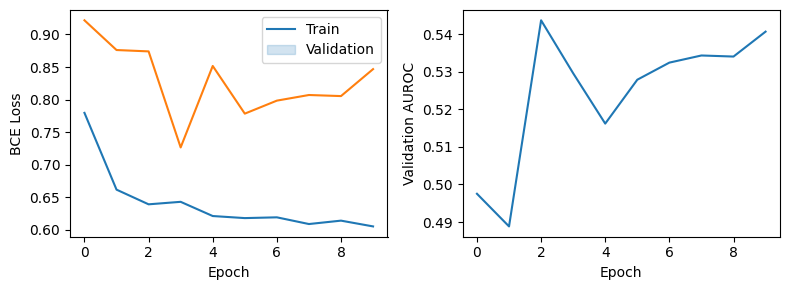

In [42]:
metrics = (
    pl.read_csv("logs/model/version_0/metrics.csv")
    .melt(["epoch", "step"], variable_name="metric")
    .drop_nulls()
)

losses = metrics.filter(pl.col("metric").str.contains("_loss"))
auroc = metrics.filter(pl.col("metric") == "valid_auroc")

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.lineplot(data=losses, x="epoch", y="value", hue="metric", ax=axs[0])
axs[0].set_ylabel("BCE Loss")
axs[0].set_xlabel("Epoch")
axs[0].legend(labels=["Train", "Validation"])

sns.lineplot(data=auroc, x="epoch", y="value", ax=axs[1])
axs[1].set_ylabel("Validation AUROC")
axs[1].set_xlabel("Epoch")

plt.tight_layout()
plt.show()

## Create a baseline model

In [15]:
from tqdm.notebook import tqdm

train_loader = DataLoader(datasets["train"], batch_size=None)
batch = next(iter(train_loader))

In [24]:
n_bins = 100
max_mz = 2000
min_mz = 140

def bin_spectra(batch, n_bins=100, min_mz=140, max_mz=2000):
    """Bin mass spectra.

    Parameters
    ----------
    batch : dict of torch.Tensor
        The batch of data.
    n_bins : int
        The number of bins.
    min_mz : float
        The lowest m/z bin.
    max_mz : float
        The highest m/z bin.
   
    Returns
    -------
    torch.Tensor
        The batch of binned mass spectra.
    """
    bins = torch.linspace(min_mz, max_mz, n_bins - 1)
    out = torch.empty(batch["mz_array"].shape[0], n_bins)
    binned = torch.bucketize(batch["mz_array"], bins)
    for i in range(out.shape[0]):
        out[i, :] = torch.bincount(
            binned[i, :], 
            weights=batch["intensity_array"][i, :], 
            minlength=n_bins,
        )

    return out


X_train, y_train = zip(*[(bin_spectra(b), b["label"]) for b in train_loader])
X_train = torch.vstack(X_train).detach().cpu().numpy()
y_train = torch.cat(y_train).detach().cpu().numpy()



xgb = XGBClassifier().fit(X_train, y_train)

## Evaluate the Models

In [51]:
X_test, y_test = zip(*[(bin_spectra(b), b["label"]) for b in valid_loader])
X_test = torch.vstack(X_test).detach().cpu().numpy()
y_test = torch.cat(y_test).detach().cpu().numpy()

baseline = xgb.predict_proba(X_test)[:, 1]

In [49]:
pred = trainer.predict(model, valid_loader)
pred = torch.vstack(pred).flatten().detach().cpu().numpy()

array([0.19893873, 0.53974104, 0.52017224, ..., 0.5559903 , 0.48018163,
       0.49183467], dtype=float32)

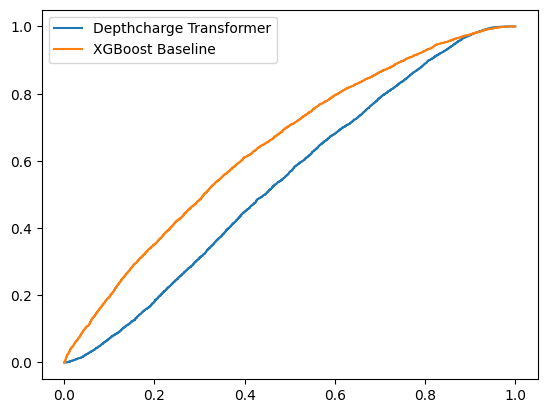

In [55]:
baseline_fpr, baseline_tpr, _ = sklearn.metrics.roc_curve(y_test, baseline)
pred_fpr, pred_tpr, _ = sklearn.metrics.roc_curve(y_test, pred)

plt.figure()
plt.step(pred_fpr, pred_tpr, where="pre", label="Depthcharge Transformer")
plt.step(baseline_fpr, baseline_tpr, where="pre", label="XGBoost Baseline")
plt.legend()
plt.show()